In [21]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
from math import pi
from utils.sim_functions import optimize_measurement
from utils.sim_functions import complete_measurement

# <span style="color:orange"> *Complete signal equation - T1 // T2* // PD & calculation of Flip Angle* </span> 

Completeing signal equation with T1 and TR block + the effect of the flip angle. <br>
Flip angle should be the ernst angle which by definition is the *arc cos* of exp(-TR/T1). Fixing TR leads to the FA needed to maximize signal from either GM or WM from the spinal cord. <br>
Signal equation for spoiled gradient-recalled echo: </br>
a
</br>
Don't forget to create your header in matlab!

### <span style="color:#BC8EC4"> *Piecewise complete simulation* </span> 

In [2]:
path_to_segmentations = ""
path_to_pd = ""
path_to_t1 = ""
path_to_t2s = ""
path_to_fm = ""
######### ####### # # ####### # # # # # # # # #### # # ### #
segmentations_img = nib.load(path_to_segmentations)
segmentations_data = segmentations_img.get_fdata()      
dimensions = np.array(segmentations_data.shape)
dimensions

array([512, 512, 828])

In [3]:
# Load nifti volumes
pd_pw_img = nib.load(path_to_pd)
pd_pw_data = pd_pw_img.get_fdata()

t2s_pw_img = nib.load(path_to_t2s)
t2s_pw_data = t2s_pw_img.get_fdata()

t1_pw_img = nib.load(path_to_t1)
t1_pw_data = t1_pw_img.get_fdata()

# This is the outcome of giving the susceptibility phantom to Susceptibility to Fieldmap repo
deltaB0_pw_img = nib.load(path_to_fm)
dB0_pw_ppm_data = deltaB0_pw_img.get_fdata()

In [2]:
# Acquisition parameters:
t1_gm = 984
t1_wm = 857
tr = 16 
fieldStrength = 3 # Tesla
fa_gm = np.rad2deg(np.arccos(np.exp(-tr/t1_gm))) # Degrees
print("FA for gm: ", fa_gm)
# Echo times
complete_TEs = [0.004, 0.008, 0.012, 0.016, 0.020, 0.024]
swiss_TE_list = [6.86*1e-3, 13.14*1e-3, 19.42*1e-3, 25.7*1e-3, 31.98*1e-3]

FA for gm:  10.304394802819381


In [5]:
complete_pw_mag, complete_pw_phase = complete_measurement(t1_pw_data, pd_pw_data, t2s_pw_data, dimensions, dB0_pw_ppm_data , fa_gm, swiss_TE_list, tr, fieldStrength, handedness='right') # By default, B0 is 3 Tesla

Starting optimize_measurement
Processing TE[0] = 0.006860000000000001  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.1788776822909693
handedness=right
Coefficient of phase factor:  5.5056066175152j
Finished optimized_signal
mag shape: (512, 512, 828), phase_arr shape: (512, 512, 828)
Processing TE[1] = 0.01314  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.1788776822909693
handedness=right
Coefficient of phase factor:  10.545724628884798j
Finished optimized_signal
mag shape: (512, 512, 828), phase_arr shape: (512, 512, 828)
Processing TE[2] = 0.019420000000000003  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.1788776822909693
handedness=right
Coefficient of phase factor:  15.5858426402544j
Finished optimized_signal
mag shape: (512, 512, 828), phase_arr shape: (512, 512, 828)
Processing TE[3] = 0.0257  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.1788776822909693
handedness=right
Coefficient of phase factor:  20.625960651624j
Finished opt

In [6]:
temp_pw_mag = nib.Nifti1Image(complete_pw_mag, affine = segmentations_img.affine)
temp_pw_ph = nib.Nifti1Image(complete_pw_phase, affine = segmentations_img.affine)


pw_magnitude_outpath = r""
pw_phase_outpath = r""

nib.save(temp_pw_mag, pw_magnitude_outpath)
nib.save(temp_pw_ph, pw_phase_outpath)

### Plotting Intensity for FA selection

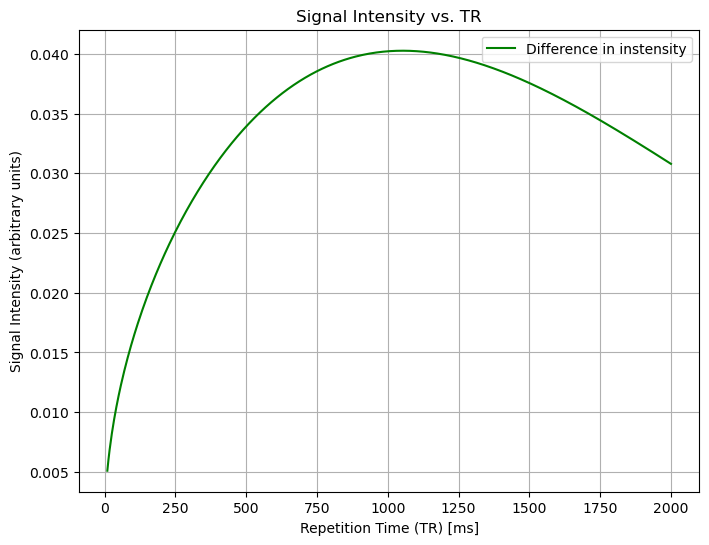

In [3]:
# What if we don't fix TR?
import numpy as np
import matplotlib.pyplot as plt

# Acquisition parameters:
t1_gm = 984
t1_wm = 857

TRs = np.linspace(10, 2000, 500)
theta_1 = np.arccos(np.exp(-TRs / t1_gm))
theta_2 = np.arccos(np.exp(-TRs / t1_wm))

E1_gm = np.exp(-TRs / t1_gm)
E1_wm = np.exp(-TRs / t1_wm)
S1 = np.sin(theta_1) * (1 - E1_gm) / (1 - E1_gm * np.cos(theta_1))
S2 = np.sin(theta_2) * (1 - E1_wm) / (1 - E1_wm * np.cos(theta_2))

# Plot
plt.figure(figsize=(8, 6))
#plt.plot(TRs, S1, label=f'T1 = {t1_gm} ms', color='blue')
#plt.plot(TRs, S2, label=f'T1 = {t1_wm} ms', color='red')
plt.plot(TRs, np.abs(S2-S1), label=f'Difference in instensity', color='green')
plt.xlabel('Repetition Time (TR) [ms]')
plt.ylabel('Signal Intensity (arbitrary units)')
plt.title('Signal Intensity vs. TR')
plt.legend()
plt.grid(True)
plt.show()

### Acquistion parameters and measurement

In [8]:
# Following the QSM recommendations for initial testing, echospacing of 8ms and we should include the T2s of tissue of interest
# In this case our last echo would be T2* of sc_gm around 40ms
complete_TEs = [0.008, 0.016, 0.024, 0.032, 0.040]

# <span style="color:#EE6594"> *Complete Cropped signal equation - T1 // T2* // PD & calculation of Flip Angle* </span> </br>
We can compute the fieldmap with all the field of view and then cropped to any size, the simulation will be realistic because the frequency offset effect is already portrayed from the whole body fieldmap calculated. </br>
For this, we are using a bounding box </br>
x: [100, 400] </br>
y: [50, 400] </br>
z: [673, 800] </br>

This is good enough coverage of the cervical spine from brain to C5

### <span style="color:#BC8EC4"> *Piecewise complete simulation* </span> 

In [4]:
path_to_cropped_segmentations = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data/ratatouille_swisss_crop.nii.gz"
path_to_cropped_pd = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\output/qsm_pd_swiss_testing.nii.gz"
path_to_cropped_t1 = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\output/qsm_t1_swiss_testing.nii.gz"
path_to_cropped_t2s = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\output/qsm_t2s_swiss_testing.nii.gz"
path_to_cropped_fm_ppm = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\output/qsm_crop_fm_ppm_swiss_testing.nii.gz"
######### ####### # # ####### # # # # # # # # #### # # ### #
cropped_segmentations_img = nib.load(path_to_cropped_segmentations)
cropped_segmentations_data = cropped_segmentations_img.get_fdata()      
cropped_dimensions = np.array(cropped_segmentations_data.shape)
cropped_dimensions

array([301, 351, 128])

In [5]:
# Load nifti volumes
crop_pd_pw_img = nib.load(path_to_cropped_pd)
crop_pd_pw_data = crop_pd_pw_img.get_fdata()

crop_t2s_pw_img = nib.load(path_to_cropped_t2s)
crop_t2s_pw_data = crop_t2s_pw_img.get_fdata()

crop_t1_pw_img = nib.load(path_to_cropped_t1)
crop_t1_pw_data = crop_t1_pw_img.get_fdata()

# This is the outcome of giving the susceptibility phantom to Susceptibility to Fieldmap repo
crop_deltaB0_pw_img = nib.load(path_to_cropped_fm_ppm)
crop_dB0_pw_ppm_data = crop_deltaB0_pw_img.get_fdata()

In [4]:
# Acquisition parameters:
t1_gm = 984
t1_wm = 857
tr_custom= 45
tr_swiss_acq = 926
fieldStrength = 3 # Tesla

fa_custom_gm = np.rad2deg(np.arccos(np.exp(-tr_custom/t1_gm))) # Degrees
fa_swiss_acq = 44
print("Custom FA for gm: ", fa_custom_gm)
# Echo times
swiss_TE_list = [6.86*1e-3, 13.14*1e-3, 19.42*1e-3, 25.7*1e-3, 31.98*1e-3]
weird_TEs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.010, 0.015, 0.020, 0.030, 0.040] # This provides better T2* fit but is unrealistic.

Custom FA for gm:  17.19615053947528


In [7]:
t1_maxi_swiss_acq = -tr_swiss_acq / np.log(np.cos(np.deg2rad(fa_swiss_acq)))

print("Swiss invivo maximizes tissue with T1 of: ", t1_maxi_swiss_acq, " [ms]")

Swiss invivo maximizes tissue with T1 of:  2810.9889375214116  [ms]


In [12]:
cropped_pw_mag, cropped_pw_phase = complete_measurement(crop_t1_pw_data, crop_pd_pw_data, crop_t2s_pw_data, cropped_dimensions, crop_dB0_pw_ppm_data , fa_custom_gm, weird_TEs, tr_custom, fieldStrength, handedness= 'right') # By default, B0 is 3 Tesla

Starting optimize_measurement
Processing TE[0] = 0.001  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.29564386827336614
handedness=right
Coefficient of phase factor:  0.8025665623199999j
Finished optimized_signal
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[1] = 0.002  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.29564386827336614
handedness=right
Coefficient of phase factor:  1.6051331246399998j
Finished optimized_signal
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[2] = 0.003  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.29564386827336614
handedness=right
Coefficient of phase factor:  2.4076996869599996j
Finished optimized_signal
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[3] = 0.004  [s]
Using T1, T2* and PD for simulation
sin($/alpha$):  0.29564386827336614
handedness=right
Coefficient of phase factor:  3.2102662492799996j
Finished optimized_signal
mag sha

In [13]:
temp_crop_pw_mag = nib.Nifti1Image(cropped_pw_mag, affine = cropped_segmentations_img.affine)
temp_crop_pw_ph = nib.Nifti1Image(cropped_pw_phase, affine = cropped_segmentations_img.affine)

cropped_pw_magnitude_outpath = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params/pw_crop_sim_mag_pro.nii.gz"
cropped_pw_phase_outpath = r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params/pw_crop_sim_ph_pro.nii.gz"

nib.save(temp_crop_pw_mag, cropped_pw_magnitude_outpath)
nib.save(temp_crop_pw_ph, cropped_pw_phase_outpath)

 # <span style="color:lime">Comparing simulations </span>

Now, lets load the simulations created, we will use the next code to compare metrics between simulations. First comparing the magnitude and phase components and then loading QSM results and comparing metrics for white and gray matter.

In [5]:
# Something used in both analysis are the metric masks, so we can load them here
gm_mask_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing/gm_mask_crop.nii.gz")
gm_mask_data = gm_mask_img.get_fdata()
wm_mask_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing/wm_mask_crop.nii.gz")
wm_mask_data = wm_mask_img.get_fdata()

 ## <span style="color:#EC407A">Magnitude and Phase analysis</span>

In [22]:
# Both simulations use the same cropping so first lets see how the magnitude changes through echoes.

custom_params_sim_mag_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params/pw_crop_sim_mag_pro.nii.gz")
custom_params_sim_mag_data = custom_params_sim_mag_img.get_fdata()
custom_params_sim_ph_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params/pw_crop_sim_ph_pro.nii.gz")
custom_params_sim_ph_data = custom_params_sim_ph_img.get_fdata()

swiss_params_sim_mag_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\in_vivo_acq_params/pw_crop_sim_mag_pro.nii.gz")
swiss_params_sim_mag_data = swiss_params_sim_mag_img.get_fdata()
swiss_params_sim_ph_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\in_vivo_acq_params/pw_crop_sim_ph_pro.nii.gz")
swiss_params_sim_ph_data = swiss_params_sim_ph_img.get_fdata()

In [23]:
n_echoes_custom = custom_params_sim_mag_data.shape[-1]
n_echoes_swiss = swiss_params_sim_mag_data.shape[-1]

wm_custom_mean = []
gm_custom_mean = []

wm_swiss_mean = []
gm_swiss_mean = []

for i in range(n_echoes_custom):
    wm_custom_vals = custom_params_sim_mag_data[..., i][wm_mask_data==1]
    gm_custom_vals = custom_params_sim_mag_data[..., i][gm_mask_data==1]

    wm_custom_mean.append(np.mean(wm_custom_vals))
    gm_custom_mean.append(np.mean(gm_custom_vals))

for i in range(n_echoes_swiss):
    wm_swiss_vals = custom_params_sim_mag_data[..., i][wm_mask_data==1]
    gm_swiss_vals = custom_params_sim_mag_data[..., i][gm_mask_data==1]

    wm_swiss_mean.append(np.mean(wm_swiss_vals))
    gm_swiss_mean.append(np.mean(gm_swiss_vals))

In [24]:
swiss_TEs = [6.86, 13.14, 19.42, 25.7, 31.98]
customs_TEs = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40] 

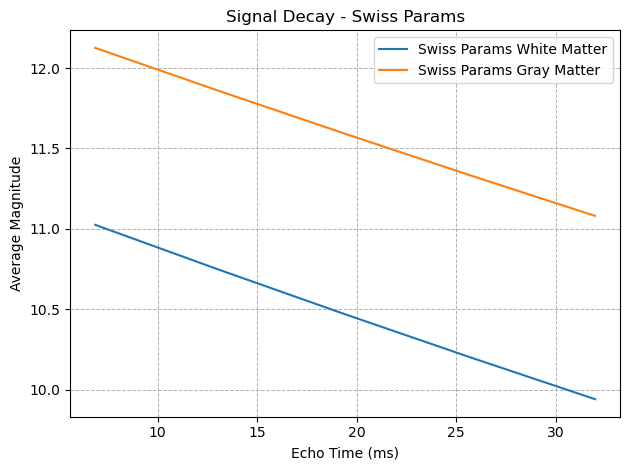

In [36]:
plt.plot(swiss_TEs, wm_swiss_mean, label='Swiss Params White Matter')
plt.plot(swiss_TEs, gm_swiss_mean, label='Swiss Params Gray Matter')
plt.xlabel('Echo Time (ms)')
plt.ylabel('Average Magnitude')
plt.title('Signal Decay - Swiss Params')
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.yticks()
plt.show()

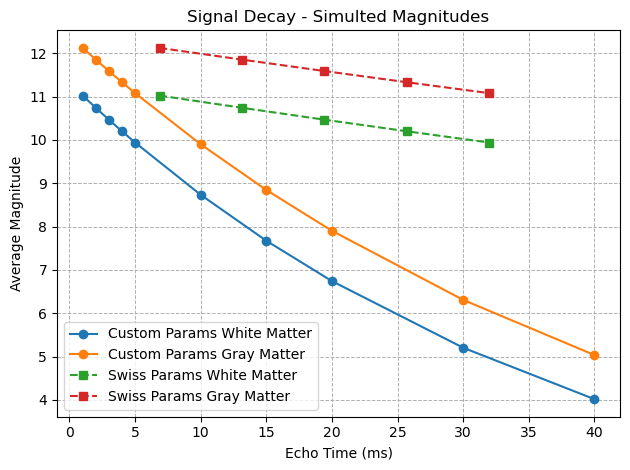

In [79]:
plt.plot(customs_TEs, wm_custom_mean,'o-', label='Custom Params White Matter')
plt.plot(customs_TEs, gm_custom_mean,'o-', label='Custom Params Gray Matter')
plt.plot(swiss_TEs, wm_swiss_mean,'s--', label='Swiss Params White Matter')
plt.plot(swiss_TEs,gm_swiss_mean,'s--', label='Swiss Params Gray Matter')
plt.xlabel('Echo Time (ms)')
plt.ylabel('Average Magnitude')
plt.title('Signal Decay - Simulted Magnitudes')
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
yticks = range(0, 15, 15) 
plt.show()

In [80]:
# Print values
print("Ideal wm mean: ", wm_custom_mean)
print("Ideal gm mean: ", gm_custom_mean)
print("Swiss wm mean: ", wm_swiss_mean)
print("Swiss gm mean: ", gm_swiss_mean)

Ideal wm mean:  [np.float64(11.024969693944893), np.float64(10.743376780592648), np.float64(10.468976138153742), np.float64(10.201584066121388), np.float64(9.941021555952794), np.float64(8.734700726121922), np.float64(7.674764242838663), np.float64(6.743448691608066), np.float64(5.206142910009048), np.float64(4.019297133997201)]
Ideal gm mean:  [np.float64(12.125471334042848), np.float64(11.855427581271076), np.float64(11.59139791458323), np.float64(11.333248395567269), np.float64(11.080848068724617), np.float64(9.900701431289233), np.float64(8.846244278739135), np.float64(7.90409026897952), np.float64(6.310122915406563), np.float64(5.037600767770554)]
Swiss wm mean:  [np.float64(11.024969693944893), np.float64(10.743376780592648), np.float64(10.468976138153742), np.float64(10.201584066121388), np.float64(9.941021555952794)]
Swiss gm mean:  [np.float64(12.125471334042848), np.float64(11.855427581271076), np.float64(11.59139791458323), np.float64(11.333248395567269), np.float64(11.08084

In [81]:
# Accuracy of T2* fit for WM and GM
# For the "ideal" params
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [82]:
def exp_decay(x, A, R2_star):
    return A * np.exp(-x * R2_star)

def fit_exp_decay(echo_times, magnitudes):
    popt, _ = curve_fit(exp_decay, echo_times, magnitudes, maxfev=10000)
    fitted_curve = exp_decay(echo_times, *popt)
    r2 = r2_score(magnitudes, fitted_curve)
    return popt, r2, fitted_curve

def plot_exp_decay(echo_times, magnitudes, popt, r2, title='Exponential Decay Fit'):
    plt.figure()
    plt.plot(echo_times, magnitudes, 'o', label='Original Data')
    plt.plot(echo_times, exp_decay(echo_times, *popt), '-', label=f'Fit (R²={r2:.3f})')
    plt.xlabel('Echo Time (ms)')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()

In [84]:
wm_custom_mean

[np.float64(11.024969693944893),
 np.float64(10.743376780592648),
 np.float64(10.468976138153742),
 np.float64(10.201584066121388),
 np.float64(9.941021555952794),
 np.float64(8.734700726121922),
 np.float64(7.674764242838663),
 np.float64(6.743448691608066),
 np.float64(5.206142910009048),
 np.float64(4.019297133997201)]

Fit parameters: A = 12.4017, R2* = 0.0225, R² = 1.0000


C:\Users\User\AppData\Local\Temp\ipykernel_39728\793340301.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-x * R2_star)


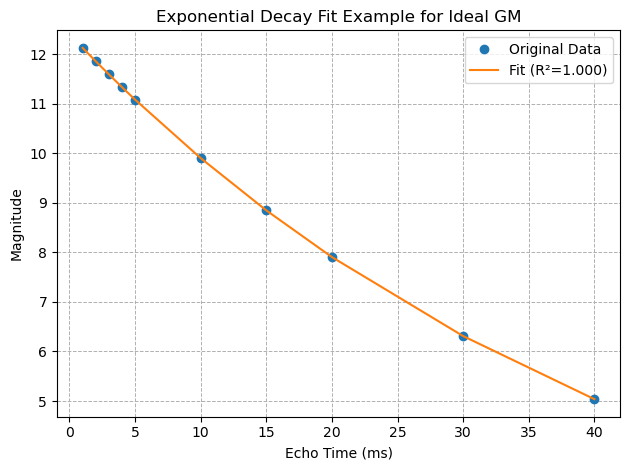

In [91]:
popt, r2, fitted_curve = fit_exp_decay(np.array(customs_TEs), np.array(gm_custom_mean))
print(f'Fit parameters: A = {popt[0]:.4f}, R2* = {popt[1]:.4f}, R² = {r2:.4f}')

plot_exp_decay(np.array(customs_TEs), np.array(gm_custom_mean), popt, r2, title='Exponential Decay Fit Example for Ideal GM')

Fit parameters: A = 11.3410, R2* = 0.0041, R² = 1.0000


C:\Users\User\AppData\Local\Temp\ipykernel_39728\793340301.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-x * R2_star)


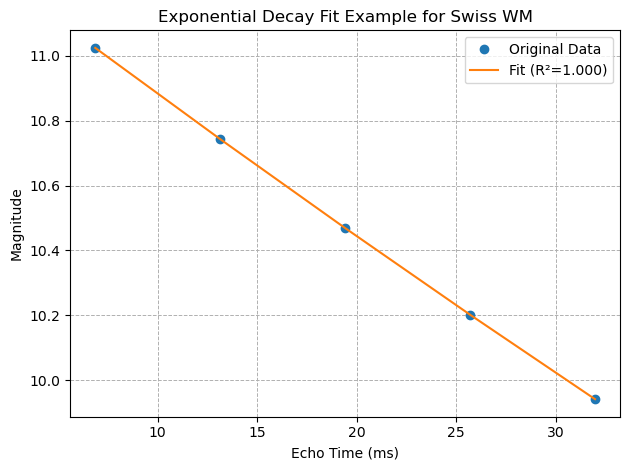

In [90]:
popt, r2, fitted_curve = fit_exp_decay(np.array(swiss_TEs), np.array(wm_swiss_mean))
print(f'Fit parameters: A = {popt[0]:.4f}, R2* = {popt[1]:.4f}, R² = {r2:.4f}')

plot_exp_decay(np.array(swiss_TEs), np.array(wm_swiss_mean), popt, r2, title='Exponential Decay Fit Example for Swiss WM')

 ## <span style="color:#009688">QSM and proceesing steps analysis</span>

### <span style="color:#9575CD">Fieldmap comparison</span>

In [8]:
fm_swiss_params_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\in_vivo_acq_params\fm_tests\test2_apply_msk/B0.nii")
fm_swiss_params_data = fm_swiss_params_img.get_fdata()

fm_custom_params_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params\fm_tests\test2_apply_msk/B0.nii")
fm_custom_params_data = fm_custom_params_img.get_fdata()

In [9]:
avg_wm_fm_swiss_params = np.mean(fm_swiss_params_data[wm_mask_data==1])
avg_gm_fm_swiss_params = np.mean(fm_swiss_params_data[gm_mask_data==1])

avg_wm_fm_custom_params = np.mean(fm_custom_params_data[wm_mask_data==1])
avg_gm_fm_custom_params = np.mean(fm_custom_params_data[gm_mask_data==1])

In [10]:
print("Average swiss params FM values: WM: ", avg_wm_fm_swiss_params, " GM: ", avg_gm_fm_swiss_params)

Average swiss params FM values: WM:  -61.532897926299405  GM:  -56.984089150734576


In [11]:
print("Average custom params FM values: WM: ", avg_wm_fm_custom_params, " GM: ", avg_gm_fm_custom_params)

Average custom params FM values: WM:  420.7994912241182  GM:  425.2404748985885


In [7]:
swiss_TEs[1] - swiss_TEs[0]

6.28

In [12]:
# It looks like there is a n*pi phase wrap happening,
B0=3
central_freq_3T = 42.58*B0 # MHz used at the desired B0
n = 1
gamma = 267.53803037970675 # rad/s.T
delta_TE_swiss = swiss_TEs[1] - swiss_TEs[0]
freq_offset_npi = (n*np.pi)/(delta_TE_swiss*1e-3)
print(f"Frequency offset from a {n} pi wrap: ",freq_offset_npi," Hz")

Frequency offset from a 1 pi wrap:  500.2536072595212  Hz


In [15]:
avg_wm_fm_swiss_corrected = avg_wm_fm_swiss_params + freq_offset_npi
avg_wm_gm_swiss_corrected = avg_gm_fm_swiss_params + freq_offset_npi

In [17]:
print("Corrected Average Swiss params FM values: WM: ", avg_wm_fm_swiss_corrected, " GM: ", avg_wm_gm_swiss_corrected)

Corrected Average Swiss params FM values: WM:  438.72070933322175  GM:  443.2695181087866


In [18]:
swiss_metrics_diff = np.abs(avg_wm_fm_swiss_params-avg_gm_fm_swiss_params)
custom_metrics_diff = np.abs(avg_wm_fm_custom_params-avg_gm_fm_custom_params)

In [19]:
print("Difference between WM and GM average on swiss params FM: ", swiss_metrics_diff)
print("Difference between WM and GM average on custom params FM: ", custom_metrics_diff)

Difference between WM and GM average on swiss params FM:  4.548808775564829
Difference between WM and GM average on custom params FM:  4.440983674470317


 ### <span style="color:#AED581">Chi map comparison</span>

In [40]:
# The value we compare to is:
chi_gm = -9.03
chi_wm = -9.083

In [42]:
# Lets load the in vivo data first
invivo_acq_chimap_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\in_vivo_QSM_processing\test2_msk_apply\Dipole_inversion_tests\TKD\test1_def/Sepia_Chimap.nii.gz")
invivo_acq_chimap_data = invivo_acq_chimap_img.get_fdata()

# Load GM & WM in vivo masks for metric calculation
invivo_acq_wm_mask_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process/mag_echo1_wm_seg_final.nii.gz").get_fdata()
invivo_acq_gm_mask_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process/mag_echo1_gmseg_corrected.nii.gz").get_fdata()


In [49]:
# Invivo metric calculation
invivo_gm_mean = np.mean(invivo_acq_chimap_data[invivo_acq_gm_mask_data==1])- 9.054
invivo_wm_mean = np.mean(invivo_acq_chimap_data[invivo_acq_wm_mask_data==1])- 9.054

print("In vivo GM average: ", invivo_gm_mean )
print("In vivo WM average: ", invivo_wm_mean )

In vivo GM average:  -9.049074327435813
In vivo WM average:  -9.054810528388735


In [50]:
# Difference from  Ground Truth value is:
print("In vivo offset from GM to ground truth: ", invivo_gm_mean - chi_gm)
print("In vivo offset from WM to ground truth: ", invivo_wm_mean - chi_wm)

In vivo offset from GM to ground truth:  -0.019074327435813387
In vivo offset from WM to ground truth:  0.02818947161126495


In [51]:
# Lets load the masks used for simulation metric calculation:
sim_gm_mask_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing/gm_mask_crop.nii.gz").get_fdata()
sim_wm_mask_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing/wm_mask_crop.nii.gz").get_fdata()

In [55]:
# Load the perfect chi map i.e. the piecewise susceptibility distribution
sim_chimap_groundtruth_ref_csf_data = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\local_field_groud_truth\ref_csf/wt_gt_chi_ref_CSF_swiss_crop_chi_dist.nii.gz.nii.gz").get_fdata()
sim_chimap_groundtruth_ref_csf_data = sim_chimap_groundtruth_ref_csf_data - 0.004

In [66]:
# Let's load the simulations now
swiss_acq_params_chimap_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\in_vivo_acq_params\dipole_inversion_tests\TKD\test1_def/Sepia_Chimap.nii.gz")
swiss_acq_params_chimap_data = swiss_acq_params_chimap_img.get_fdata()

custom_acq_params_chimap_img = nib.load(r"E:\msc_data\sc_qsm\Swiss_data\march_25_re_process\MR_simulations\sim_data\QSM_processing\mrsim_outputs\custom_acq_params\dipole_inversion_tests\TKD\test1_def/Sepia_Chimap.nii.gz")
custom_acq_params_chimap_data = custom_acq_params_chimap_img.get_fdata()

In [72]:
# Now lets compute the metrics
swiss_pixel_wise_difference = swiss_acq_params_chimap_data - sim_chimap_groundtruth_ref_csf_data
custom_pixel_wise_difference = custom_acq_params_chimap_data - sim_chimap_groundtruth_ref_csf_data

In [73]:
swiss_gm_diff = swiss_pixel_wise_difference[sim_gm_mask_data==1]
swiss_wm_diff = swiss_pixel_wise_difference[sim_wm_mask_data==1]

swiss_gm_mean_diff = np.mean(swiss_gm_diff)
swiss_gm_std_diff = np.std(swiss_gm_diff)
swiss_gm_rmse = np.sqrt(np.mean(swiss_gm_diff ** 2))

swiss_wm_mean_diff = np.mean(swiss_wm_diff)
swiss_wm_std_diff = np.std(swiss_wm_diff)
swiss_wm_rmse = np.sqrt(np.mean(swiss_wm_diff ** 2))

In [74]:
print("Swiss GM vs GT")
print(f"  Mean difference: {swiss_gm_mean_diff:.5f}")
print(f"  Std deviation: {swiss_gm_std_diff:.5f}")
print(f"  RMSE: {swiss_gm_rmse:.5f}")

print("Swiss WM vs GT")
print(f"  Mean difference: {swiss_wm_mean_diff:.5f}")
print(f"  Std deviation: {swiss_wm_std_diff:.5f}")
print(f"  RMSE: {swiss_wm_rmse:.5f}")

Swiss GM vs GT
  Mean difference: 0.00295
  Std deviation: 0.01135
  RMSE: 0.01173
Swiss WM vs GT
  Mean difference: 0.01218
  Std deviation: 0.01461
  RMSE: 0.01902


In [75]:
custom_gm_diff = custom_pixel_wise_difference[sim_gm_mask_data==1]
custom_wm_diff = custom_pixel_wise_difference[sim_wm_mask_data==1]

custom_gm_mean_diff = np.mean(custom_gm_diff)
custom_gm_std_diff = np.std(custom_gm_diff)
custom_gm_rmse = np.sqrt(np.mean(custom_gm_diff ** 2))

custom_wm_mean_diff = np.mean(custom_wm_diff)
custom_wm_std_diff = np.std(custom_wm_diff)
custom_wm_rmse = np.sqrt(np.mean(custom_wm_diff ** 2))

In [76]:
print("Custom GM vs GT")
print(f"  Mean difference: {custom_gm_mean_diff:.5f}")
print(f"  Std deviation: {custom_gm_std_diff:.5f}")
print(f"  RMSE: {custom_gm_rmse:.5f}")

print("Custom WM vs GT")
print(f"  Mean difference: {custom_wm_mean_diff:.5f}")
print(f"  Std deviation: {custom_wm_std_diff:.5f}")
print(f"  RMSE: {custom_wm_rmse:.5f}")

Custom GM vs GT
  Mean difference: 0.00795
  Std deviation: 0.01144
  RMSE: 0.01393
Custom WM vs GT
  Mean difference: 0.01953
  Std deviation: 0.01016
  RMSE: 0.02201
